In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image_dataset
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D


In [3]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.1
FROZEN_LAYER_NUM = 19
ADAM_LEARNING_RATE = 0.001

Model Initialization


leave the weights of the feature extraction layers unchanged, only train on the weights of the fully connected and final classification layer

In [4]:
vgg_model = VGGFace(model="vgg16", include_top=False, input_shape=(48,48,3),pooling="avg")
# print(vgg_model.summary())

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_model.layers[i].trainable = False

print(vgg_model.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_model.input, out)
print(model.summary())

optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=10, min_lr=0.001)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

False
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 24, 24, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 128)

load in preprocessed data

In [5]:
def load_data(train_path, test_path):
    train_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="training")
    val_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="validation")
    test_data = image_dataset.image_dataset_from_directory(
            test_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True)
    return train_data, val_data, test_data

# configuration for better performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)
train_data, valid_data, test_data = load_data("dataset2/train", "dataset2/test")

Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.


In [6]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
    )


Epoch 1/50
138/138 [==============================] - 141s 1s/step - loss: 5.9781 - accuracy: 0.3068 - val_loss: 1.6298 - val_accuracy: 0.3767
Epoch 2/50
138/138 [==============================] - 146s 1s/step - loss: 1.6143 - accuracy: 0.3793 - val_loss: 1.5830 - val_accuracy: 0.3960
Epoch 3/50
138/138 [==============================] - 154s 1s/step - loss: 1.5477 - accuracy: 0.4066 - val_loss: 1.5708 - val_accuracy: 0.3973
Epoch 4/50
138/138 [==============================] - 154s 1s/step - loss: 1.4925 - accuracy: 0.4266 - val_loss: 1.5702 - val_accuracy: 0.4146
Epoch 5/50
138/138 [==============================] - 169s 1s/step - loss: 1.4447 - accuracy: 0.4534 - val_loss: 1.5562 - val_accuracy: 0.4134
Epoch 6/50
138/138 [==============================] - 176s 1s/step - loss: 1.3923 - accuracy: 0.4746 - val_loss: 1.5780 - val_accuracy: 0.4139
Epoch 7/50
138/138 [==============================] - 176s 1s/step - loss: 1.3342 - accuracy: 0.4971 - val_loss: 1.5584 - val_accuracy: 0.4302

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


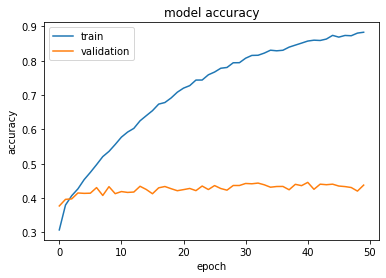

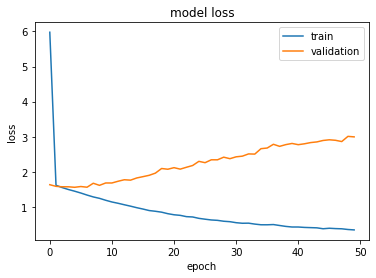

In [7]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('results/VGG16_dense1024' + epoch_str + dropout_str + '-accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('results/VGG16_dense1024' + epoch_str + dropout_str + '-loss.png')
plt.show()

In [8]:
print('\n# Evaluate on validation data')
results_val = model.evaluate(valid_data, batch_size=BS)
print('validation loss, validation accuracy:', results_val)


# Evaluate on validation data
35/35 [==============================] - 103s 3s/step - loss: 2.9938 - accuracy: 0.4375
validation loss, validation accuracy: [2.9937853813171387, 0.43748581409454346]


In [9]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_data, batch_size=BS)
print('test loss, test accuracy:', results_test)


# Evaluate on test data
44/44 [==============================] - 124s 3s/step - loss: 2.8836 - accuracy: 0.4537
test loss, test accuracy: [2.8835604190826416, 0.4537372887134552]


In [1]:
Y = model

NameError: name 'model' is not defined